In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import pickle


### Загрузка датасета

In [2]:
df = pd.read_csv("../data/car data.csv")

In [3]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Driven_kms,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.642584,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


* Кол-во записей в выборке равно 301
* Все признаки лежат в пределах своих разумных значений

### Очистка данных

In [6]:
df["Year"] = df["Year"].astype('category')
df["Car_Name"] = df["Car_Name"].astype('category')
df["Fuel_Type"] = df["Fuel_Type"].astype('category')
df["Selling_type"] = df["Selling_type"].astype('category')
df["Transmission"] = df["Transmission"].astype('category')
df["Selling_Price"] = df["Selling_Price"].astype('float16')
df["Present_Price"] = df["Present_Price"].astype('float16')
df["Driven_kms"] = df["Driven_kms"].astype('int32')
df["Owner"] = df["Owner"].astype('int8')

Провели редактирование типов данных признаков


In [7]:
print(f'Число дубликатов = {int(df.duplicated().sum())+1}')

Число дубликатов = 3


Было обнаружено три дубликата, удалим их

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
# Уменьшили размер в 2 раза
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Car_Name       299 non-null    category
 1   Year           299 non-null    category
 2   Selling_Price  299 non-null    float16 
 3   Present_Price  299 non-null    float16 
 4   Driven_kms     299 non-null    int32   
 5   Fuel_Type      299 non-null    category
 6   Selling_type   299 non-null    category
 7   Transmission   299 non-null    category
 8   Owner          299 non-null    int8    
dtypes: category(5), float16(2), int32(1), int8(1)
memory usage: 10.3 KB


Уменьшили размер исходной выборки в два раза

Категориальные признаки

In [10]:
cat_features = df.select_dtypes(include=['category']).columns.to_list()
cat_features

['Car_Name', 'Year', 'Fuel_Type', 'Selling_type', 'Transmission']

Числовые признаки

In [11]:
num_features = df.select_dtypes(include=['number']).columns.to_list()
num_features

['Selling_Price', 'Present_Price', 'Driven_kms', 'Owner']

### Анализ признаков для модели

##### Зависимость цены продажи от года машины

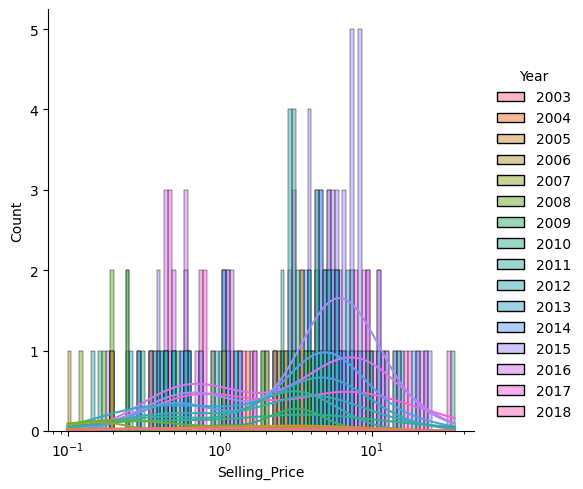

In [12]:
sns.displot(df, x='Selling_Price', bins=100, hue='Year', kde=True, log_scale=True)

Выводы:
- Автомобили старых лет 2003-2007, хотя их и немного в основном продаются по более низким ценам, новые же автомобили 2014-2018 в основном продаются по высоким ценам
- Также по графику видно, что существует широкий разброс в ценах внутри одного и того же года выпуска

##### Зависимость цены покупки от года машины

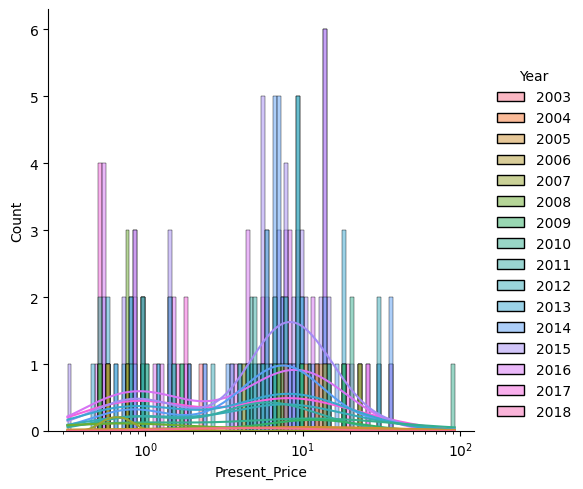

In [13]:
sns.displot(df, x='Present_Price', bins=100, hue='Year', kde=True, log_scale=True)


Выводы:
- Здесь наблюдаем примерно ту же картину, что и с ценой продажи, но разброс цены в пределах одного года здесь немного выше

##### Зависимость пробега от года выпуска машины

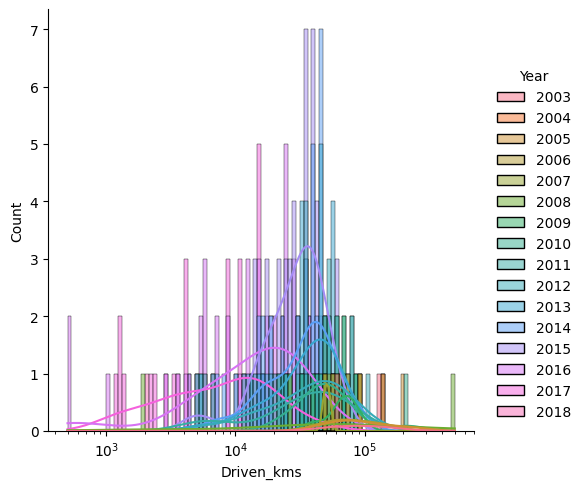

In [14]:
sns.displot(df, x='Driven_kms', bins=100, hue='Year', kde=True, log_scale=True)

Выводы:
- Для автомобилей старых лет 2003-2007, наблюдаются высокие значения пробега, новые же машины(2014-2018) в большинстве своем имеют более низкие значения пробега
- Пробег автомобилей коррелирует с годом выпуска

##### Создание нового признака

In [15]:
# Создаем новый признак - уровень пробега
df['mileage_level'] = df.apply(lambda x: 'low' if x['Driven_kms'] <= 20000 \
                               else 'high' if x['Driven_kms'] >= 45000 \
                               else 'mid', axis = 1)

Добавили новый категориальный признак - уровень пробега

In [16]:
df["mileage_level"] = df["mileage_level"].astype('category')

In [17]:
df.tail(5)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
296,city,2016,9.500000,11.601562,33988,Diesel,Dealer,Manual,0,mid
297,brio,2015,4.000000,5.898438,60000,Petrol,Dealer,Manual,0,high
298,city,2009,3.349609,11.000000,87934,Petrol,Dealer,Manual,0,high
299,city,2017,11.500000,12.500000,9000,Diesel,Dealer,Manual,0,low
300,brio,2016,5.300781,5.898438,5464,Petrol,Dealer,Manual,0,low


In [18]:
df['mileage_level'].value_counts()

mid     105
low     101
high     93
Name: mileage_level, dtype: int64

Получили примерно равное количество уровней пробега

##### Зависимость цены машины от величины пробега

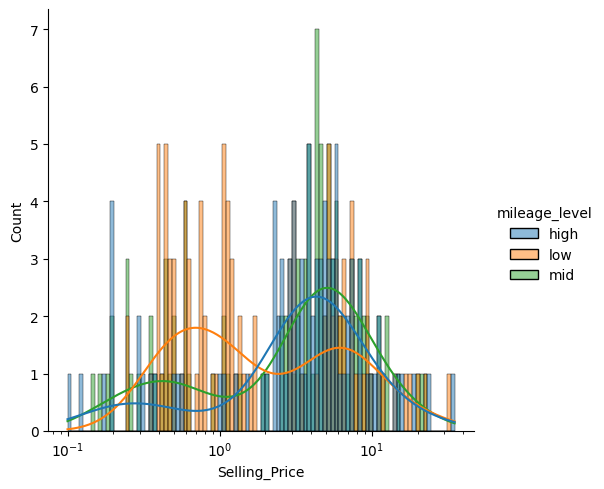

In [19]:
sns.displot(df, x='Selling_Price', bins=100, hue='mileage_level', kde=True, log_scale=True)

Выводы:
- Видно что даже машины с низким пробегом продаются за разные сумммы, вероятно всё это зависит от марки машины и её класса
- Машины же с высоким пробегом в большинстве продаются за одни и те же суммы

##### Тепловая карта

In [20]:
cat_features = df.select_dtypes(include=['category']).columns.to_list()
cat_features

['Car_Name',
 'Year',
 'Fuel_Type',
 'Selling_type',
 'Transmission',
 'mileage_level']

In [21]:
num_features = df.select_dtypes(include=['number']).columns.to_list()
num_features

['Selling_Price', 'Present_Price', 'Driven_kms', 'Owner']

<Axes: >

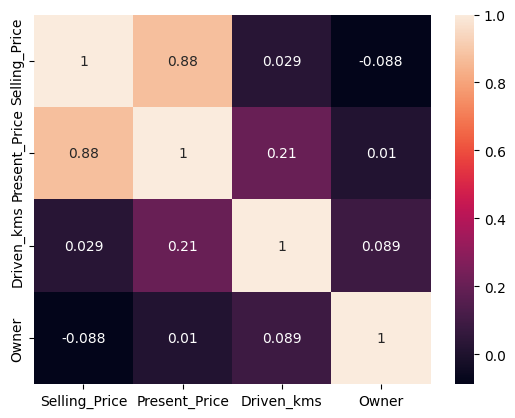

In [22]:
feature_correlation = df[num_features].corr()
sns.heatmap(feature_correlation, annot=True)

Выводы:
- Наблюдаем очевидную корреляцию между ценой продажи и ценой покупки
- Но, почему-то, цена продажи автомобиля не коррелирует с пробегом

In [23]:
def flat_index(df_stats): 
    df_stats.columns = df_stats.columns.get_level_values(0) + '_' +  df_stats.columns.get_level_values(1) 
    df_stats.columns = df_stats.columns.to_flat_index() 
    df_stats.reset_index(inplace=True) 
    return df_stats

aggregated_df = flat_index(df[num_features+['Year']].groupby(by='Year').agg(['mean', 'std']))
aggregated_df

,Year,Selling_Price_mean,Selling_Price_std,Present_Price_mean,Present_Price_std,Driven_kms_mean,Driven_kms_std,Owner_mean,Owner_std
0,2003,1.300049,1.343434,5.129883,4.031337,94500.000000,45961.940777,0.000000,0.000000
1,2004,1.500000,NaN,12.351562,NaN,135154.000000,NaN,0.000000,NaN
2,2005,2.487488,1.565491,9.486206,6.153806,104294.000000,63559.476692,0.000000,0.000000
3,2006,1.437347,1.081137,9.058594,10.175851,87422.250000,40295.305950,0.750000,1.500000
4,2007,0.159973,0.056537,0.665039,0.120153,51000.000000,2828.427125,0.500000,0.707107
5,2008,1.002877,1.471779,4.759556,8.305253,112128.571429,173231.489769,0.142857,0.377964
6,2009,2.816650,1.085745,10.601562,5.902264,67820.500000,16201.723411,0.000000,0.000000
7,2010,5.262606,8.766931,14.332877,23.118814,60014.066667,45429.155164,0.066667,0.258199
8,2011,2.375251,1.477055,5.147795,3.927056,40327.368421,23467.977897,0.052632,0.229416
9,2012,3.841192,3.942804,7.984502,8.517218,43798.217391,25502.573966,0.043478,0.208514


Применим агрегирующие фунции с группировкой по году выпуска автомобиля

##### Зависимости

<Axes: xlabel='Year', ylabel='Selling_Price_std'>

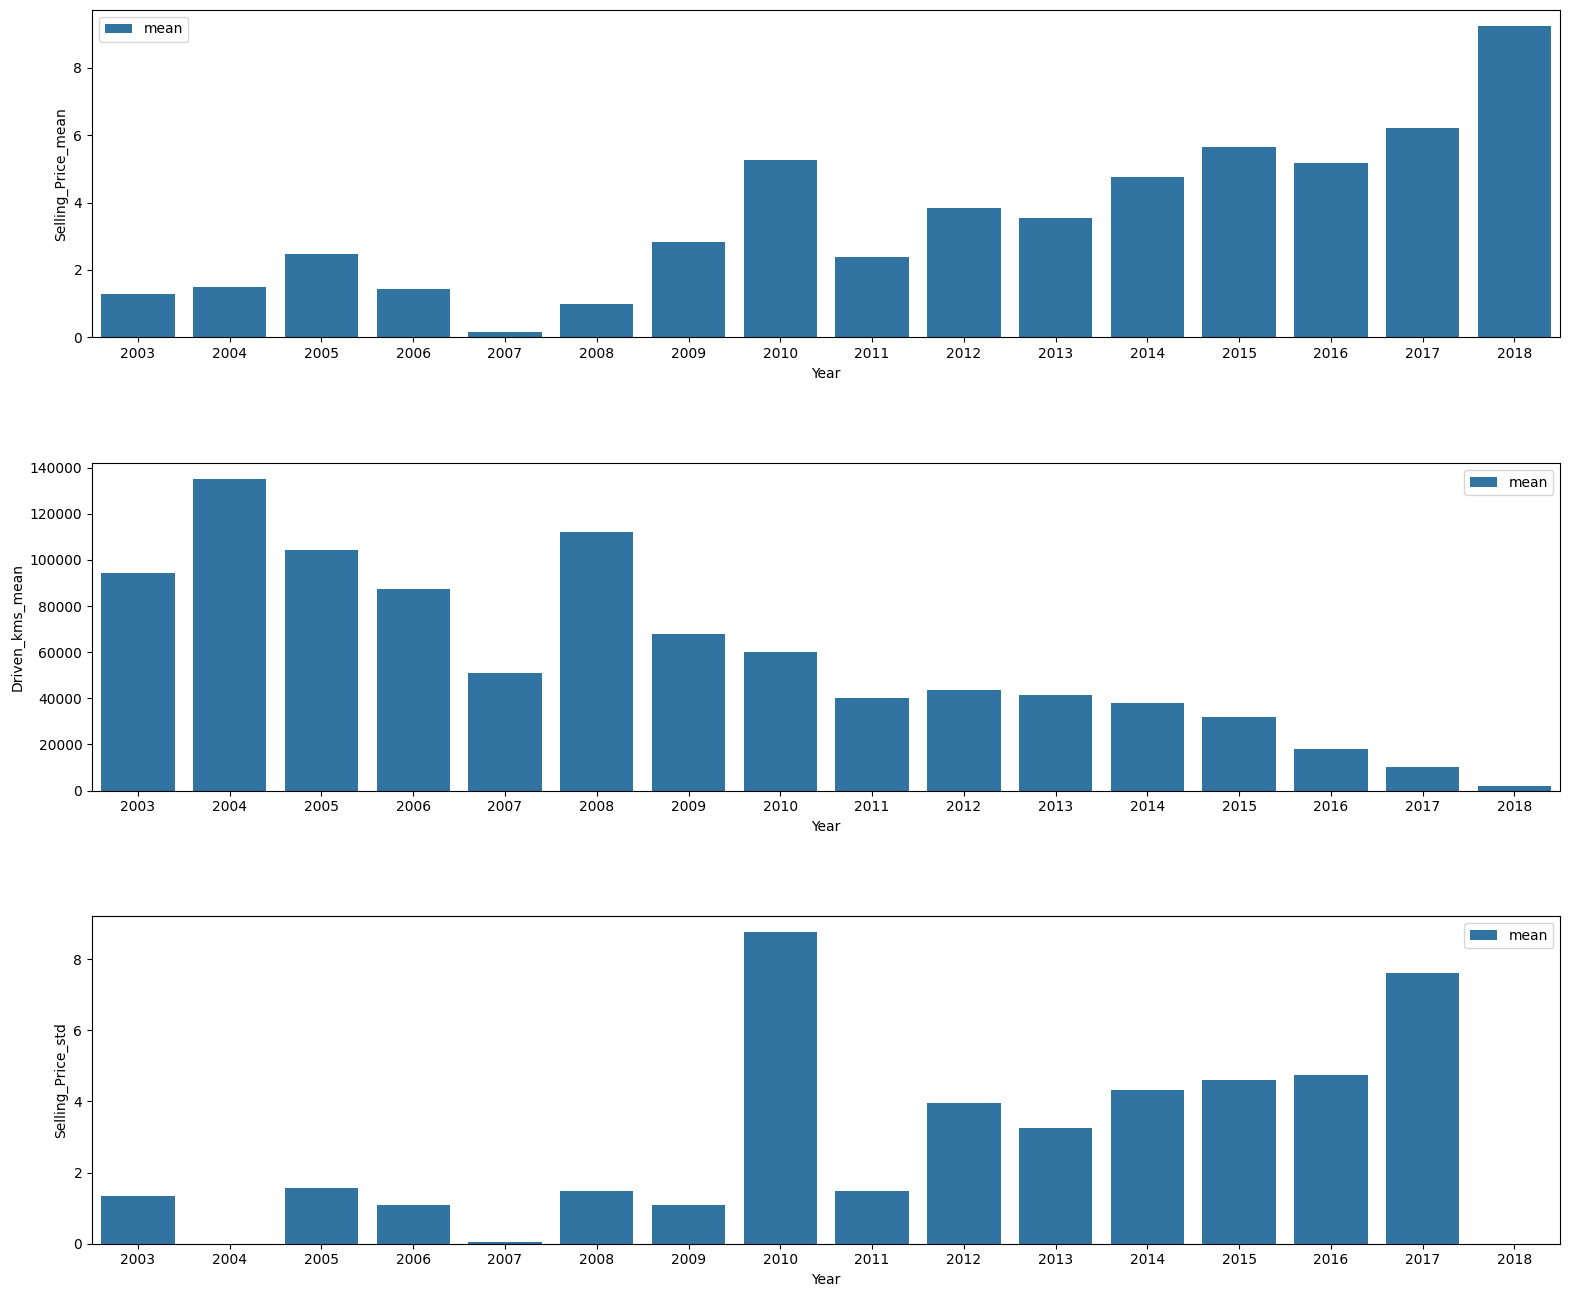

In [24]:
fig, axs = plt.pyplot.subplots(3,1)
fig.tight_layout(pad=1)
fig.set_size_inches(16.5, 14, forward=True)

sns.barplot(aggregated_df,x='Year',y='Selling_Price_mean', label='mean', ax=axs[0])
sns.barplot(aggregated_df,x='Year',y='Driven_kms_mean', label='mean', ax=axs[1])
sns.barplot(aggregated_df,x='Year',y='Selling_Price_std', label='mean', ax=axs[2])

Выводы:
- Первый график
  - Видно, что цена продажи растет с годом выпуска машины, чем дороже машина, тем она новее, что очевидно
- Второй график
  - Пробег автомобиля падает с годом его выпуска, что тоже логично
- Третий график
  - Дисперсия цены продажи увеличивается с годом выпуска автомобиля, то есть новые автомобили имеют больший разброс в цене

In [25]:
def flat_index(df_stats): 
    df_stats.columns = df_stats.columns.get_level_values(0) + '_' +  df_stats.columns.get_level_values(1) 
    df_stats.columns = df_stats.columns.to_flat_index() 
    df_stats.reset_index(inplace=True) 
    return df_stats

aggregated_df_fuel = flat_index(df[num_features+['Fuel_Type']].groupby(by='Fuel_Type').agg(['mean', 'std']))
aggregated_df_fuel

,Fuel_Type,Selling_Price_mean,Selling_Price_std,Present_Price_mean,Present_Price_std,Driven_kms_mean,Driven_kms_std,Owner_mean,Owner_std
0,CNG,3.099609,0.212684,6.414062,1.872728,42749.000000,10251.634114,0.000000,0.000000
1,Diesel,10.102438,7.103011,15.646889,13.563592,50675.775862,30495.519576,0.017241,0.131306
2,Petrol,3.264136,3.135525,5.583563,5.287752,33528.937238,40308.984886,0.050209,0.270368


Применим агрегирующие фунции с группировкой по типу топлива

<Axes: xlabel='Fuel_Type', ylabel='Selling_Price_std'>

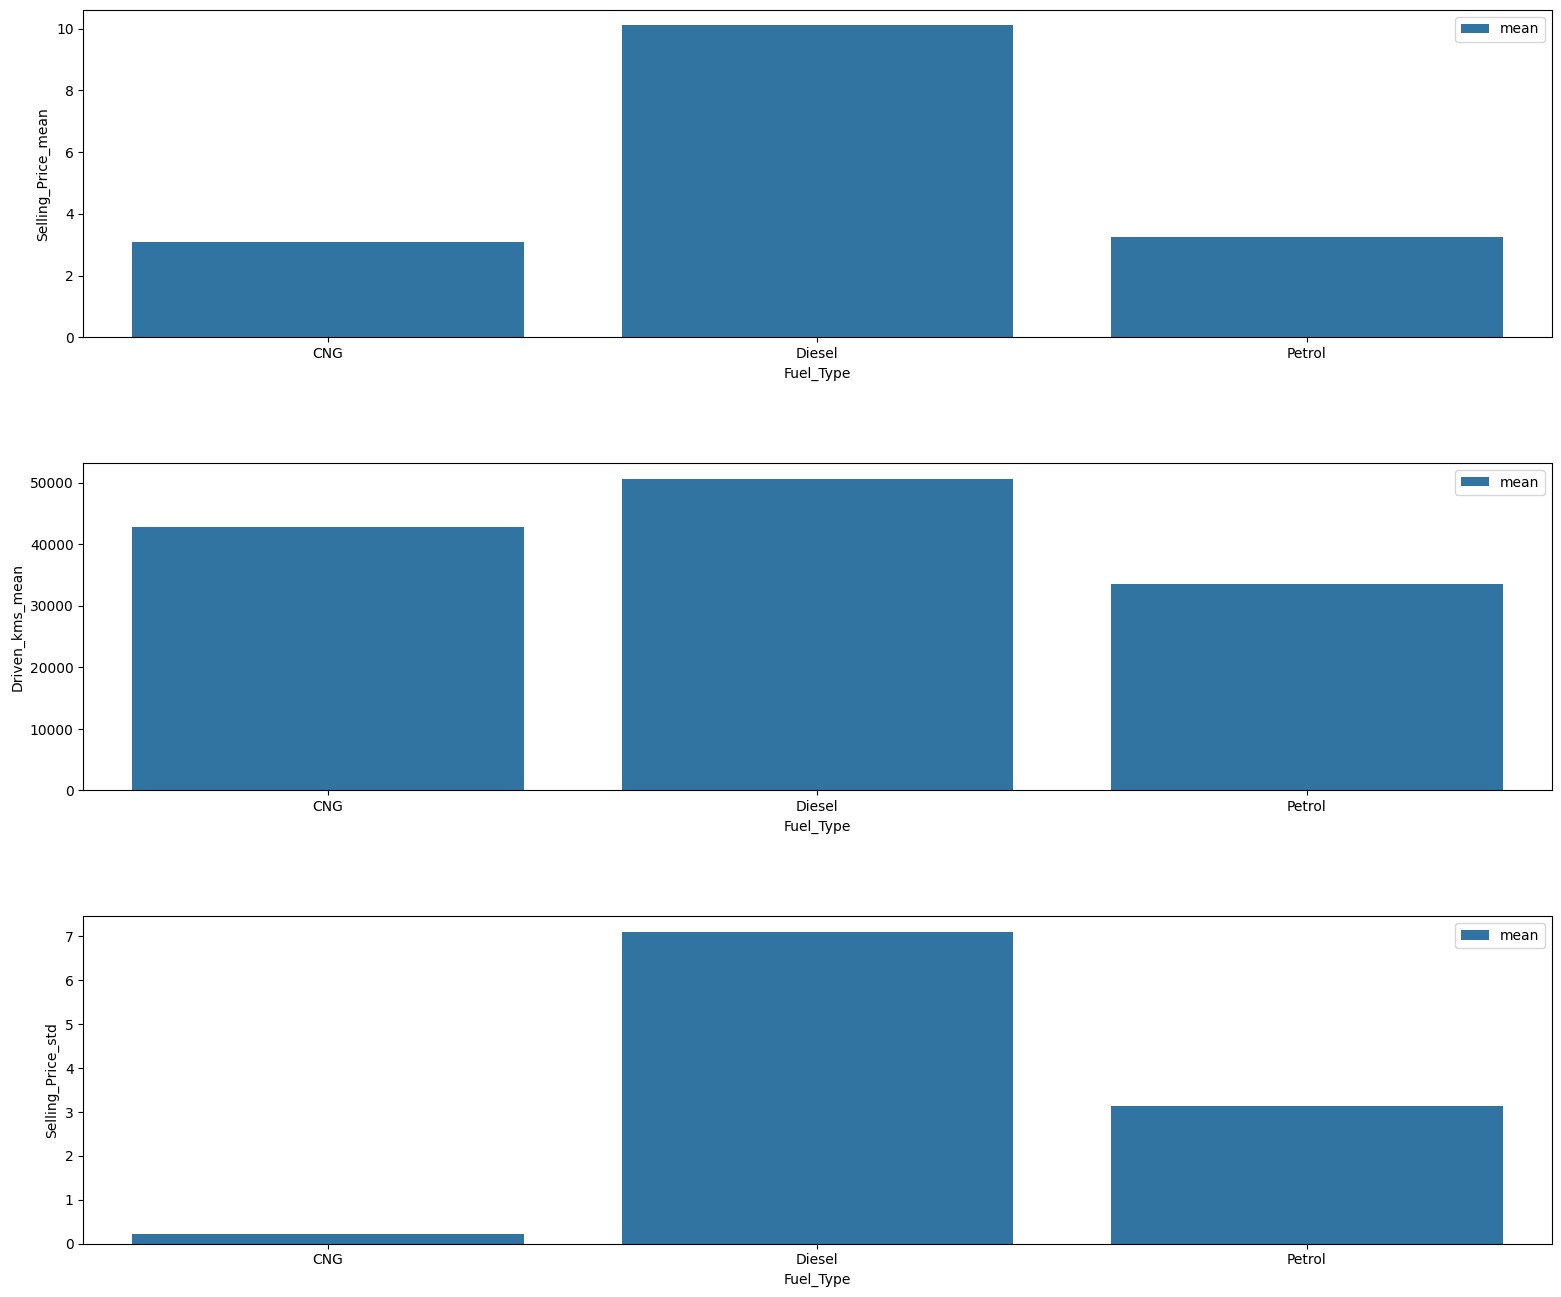

In [26]:
fig, axs = plt.pyplot.subplots(3,1)
fig.tight_layout(pad=1)
fig.set_size_inches(16.5, 14, forward=True)


sns.barplot(aggregated_df_fuel,x='Fuel_Type',y='Selling_Price_mean', label='mean', ax=axs[0])
sns.barplot(aggregated_df_fuel,x='Fuel_Type',y='Driven_kms_mean', label='mean', ax=axs[1])
sns.barplot(aggregated_df_fuel,x='Fuel_Type',y='Selling_Price_std', label='mean', ax=axs[2])

Выводы:
- Первый график
  - Машины с типом топлива "Diesel" самые дорогие, самые дешевые - с типом топлива "CNG"
- Второй график
  - Самый большой пробег у автомобилей с типом топлива "Diesel", самый маленький у автомобилей с типом топлива "Petrol"
- Третий график
  - Машины с типом топлива "Diesel" имают самый большой разброс в цене, самый низкий - с типом топлива "CNG"

In [27]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource,  HoverTool, Legend 
from bokeh.io import output_notebook 
output_notebook()

Loading BokehJS ...

In [28]:
source = ColumnDataSource(data=df.sample(frac=1))
p = figure(width=1000)
p.scatter(source=source, x='Year', y='Selling_Price' )
hover = HoverTool(tooltips=[('year', '@Year'),
                              ('price', '@Selling_Price'),
                              ('mileage', '@mileage_level')])

p.add_tools(hover)
show(p)

Вывод:
- Средняя стоимость автомобиля растет с годом выпуска автомбобиля, также видно, что в выборке больше всего новых автомобилей 2012-2018 года выпуска

In [29]:
source = ColumnDataSource(data=df.sample(frac=1))
p = figure(width=1000)
p.scatter(source=source, x='Driven_kms', y='Selling_Price' )
hover = HoverTool(tooltips=[('year ', '@Year'),
                              ('price', '@Selling_Price'),
                              ('mileage', '@mileage_level')])

p.add_tools(hover)
show(p)

Вывод:
- Видно, что в выборке большинство автомобилей имеют пробег до 40000 км
- По данным выводам видно, что стоимость автомобиля почти не зависит от его пробега

In [30]:
df.head(3)

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,mileage_level
0,ritz,2014,3.349609,5.589844,27000,Petrol,Dealer,Manual,0,mid
1,sx4,2013,4.750000,9.539062,43000,Diesel,Dealer,Manual,0,mid
2,ciaz,2017,7.250000,9.851562,6900,Petrol,Dealer,Manual,0,low


In [31]:
source = ColumnDataSource(data=df.sample(frac=1))
p = figure(width=1000)
p.scatter(source=source, x='Owner', y='Selling_Price' )
hover = HoverTool(tooltips=[('year ', '@Year'),
                              ('price', '@Selling_Price'),
                              ('mileage', '@mileage_level')])

p.add_tools(hover)
show(p)

Выводы:
- Видно, что что больше всего машин в выборке - новые
- Самые дорогие машины - без единого владельца, машины с хотя бы оним владельцем стоят значительно дешевле

##### Сохранение финального датасета

In [32]:
df.to_pickle("../data/car_data_edited.pkl")